In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as functional
import torch.nn.init as init
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset, Subset
from datasets import CustomCIFAR10, train_transforms, test_transforms
from models import resnet20

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Seed everything
seed = 24
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
def register_hook(task, layer_name):
    # the hook signature
    def hook(model, input, output):
        """
        According to what Chris said to Jason, to turn the feature map to input vector for MMD,
        I extracted patches the size of the filter, and vectorize each patch.
        (e.g. input = (batch_size, C, H, W)
              -> a filter size of (3 x 3), padding 1, stride 1
              -> (batch_size, C x 3 x 3, number_of_patches)
              -> (number_of_patches, batch_size, C x 3 x 3)
        )

        When computing MMD, we iterate the number of patches.
        At each iteration, we compute mmd between two groups of (C x 3 x 3)-dim vectors, each group having batch_size samples.
        And we take the mean mmd of all the patches. (Intuitively we are computing mean mmd of all patches.)
        """
        unfold = nn.Unfold(kernel_size=model.kernel_size, padding=model.padding, stride=model.stride)
        features = unfold(input[0].detach())
        features = features.permute(2, 0, 1)

        task[layer_name] = features

    return hook

def register_hooks(model, task, module_type):
    hook_handler = []
    for name, module in model.named_modules():
        if isinstance(module, module_type):
            handle = module.register_forward_hook(register_hook(task, name))
            hook_handler.append(handle)
    return hook_handler

def remove_hooks(hook_handler):
    for handle in hook_handler:
        handle.remove()

def get_bw(X, Y):
    size = X.size(0)
    if (size < 2000):
        num_samples = size
        combined = torch.cat([X, Y], dim=0)
    else:
        num_samples = 2000
        subset_t0 = X[torch.randperm(size)[:num_samples]]
        subset_t1 = X[torch.randperm(size)[:num_samples]]
        combined = torch.cat([subset_t0, subset_t1], dim=0)
    distances = functional.pdist(combined)
    bandwidth = distances.median()
    return bandwidth.item()

# def MMD(x, y, bandwidth):
#     """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

#     Args:
#         x: first set of sample, distribution P, shape (num_of_samples, feature_dim)
#         y: second set of sample, distribution Q, shape (num_of_samples, feature_dim)
#         bandwidth: kernel bandwidth of the RBF kernel
#     """

#     xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
#     rx = (xx.diag().unsqueeze(0).expand_as(xx))
#     ry = (yy.diag().unsqueeze(0).expand_as(yy))

#     dxx = rx.t() + rx - 2. * xx # Used for A in (1)
#     dyy = ry.t() + ry - 2. * yy # Used for B in (1)
#     dxy = rx.t() + ry - 2. * zz # Used for C in (1)

#     sigma2 = bandwidth * bandwidth

#     XX = torch.exp(-0.5*dxx/sigma2)
#     YY = torch.exp(-0.5*dyy/sigma2)
#     XY = torch.exp(-0.5*dxy/sigma2)

#     return torch.mean(XX + YY - 2. * XY).item()

def MMD_patch(x, y, bandwidth):
    """Compute MMD for batches of features.

    Args:
        x, y: (num_of_patches, batchsize, feature_dim)
        bandwidth: kernel bandwidth of the RBF kernel
    """
    assert x.shape[0] == y.shape[0], "Patch num of x and y must be the same"

    batch_size = x.shape[0]
    mmd_accumulated = 0.0

    for i in range(batch_size):
        xi, yi = x[i], y[i]
        if bandwidth == None:
            # Use the median of the two distributions as bandwidth
            combined = torch.cat([xi, yi], dim=0)
            distances = functional.pdist(combined)
            bandwidth = distances.median()

        xx, yy, zz = torch.mm(xi, xi.t()), torch.mm(yi, yi.t()), torch.mm(xi, yi.t())
        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx.t() + rx - 2. * xx
        dyy = ry.t() + ry - 2. * yy
        dxy = rx.t() + ry - 2. * zz

        sigma2 = bandwidth * bandwidth

        XX = torch.exp(-0.5*dxx/sigma2)
        YY = torch.exp(-0.5*dyy/sigma2)
        XY = torch.exp(-0.5*dxy/sigma2)

        mmd_accumulated += torch.mean(XX + YY - 2. * XY)

    return (mmd_accumulated / batch_size).item()


def get_MMD_at_every_layer(model, data_loader1, data_loader2, bandwidth = None):
    model.eval()
    model.to(device)
    MMD_mean_at_every_layer = {}

    for i, ((X1, _), (X2, _)) in enumerate(zip(data_loader1, data_loader2)):
        t0 = {}
        t1 = {}
        X1 = X1.to(device)
        X2 = X2.to(device)

        hook_handler = register_hooks(model, t0, (nn.Conv2d, ))
        with torch.no_grad():
            model(X1)
        remove_hooks(hook_handler)

        hook_handler = register_hooks(model, t1, (nn.Conv2d, ))
        with torch.no_grad():
            model(X2)
        remove_hooks(hook_handler)

        for key in t0.keys():
            if i == 0: # initialize dict
                MMD_mean_at_every_layer[key] = 0
            MMD_mean_at_every_layer[key] += MMD_patch(t0[key], t1[key], bandwidth)

    for key in MMD_mean_at_every_layer.keys():
        MMD_mean_at_every_layer[key] /= (i + 1)
    return MMD_mean_at_every_layer


In [3]:
# Load CIFAR10 test dataset
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# Get the targets (labels) of the test set
targets = np.array(cifar10_test.targets)

# Split the dataset indices by class
indices_1 = []
indices_2 = []

for i in range(10):  # Since CIFAR10 has 10 classes
    class_indices = np.where(targets == i)[0]
    np.random.shuffle(class_indices)

    # Split the indices for each class into two: 500 for indices_1 and 500 for indices_2
    indices_1.extend(class_indices[:500])
    indices_2.extend(class_indices[500:])

# Create the two subsets
test_dataset_1 = Subset(cifar10_test, indices_1)
test_dataset_2 = Subset(cifar10_test, indices_2)

test_dataset_3 = CustomCIFAR10(root='/content/data', train=False, transform=test_transforms, download=False, min_label=0, max_label=4, imgs_per_class=1000)
test_dataset_4 = CustomCIFAR10(root='/content/data', train=False, transform=test_transforms, download=False, min_label=5, max_label=9, imgs_per_class=1000)


100%|██████████| 170498071/170498071 [00:05<00:00, 30197041.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
# Randomized model
model_random = resnet20()
model_random = model_random.to(device)


In [21]:
# Setting 1
test_loader_1 = DataLoader(test_dataset_1, batch_size=1000, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=1000, shuffle=True)

MMD_mean_at_randominit_setting1 = get_MMD_at_every_layer(model_random, test_loader_1, test_loader_2)

# Setting 2
test_loader_3 = DataLoader(test_dataset_3, batch_size=1000, shuffle=True)
test_loader_4 = DataLoader(test_dataset_4, batch_size=1000, shuffle=True)
MMD_mean_at_randominit_setting2 = get_MMD_at_every_layer(model_random, test_loader_3, test_loader_4)
torch.cuda.empty_cache()

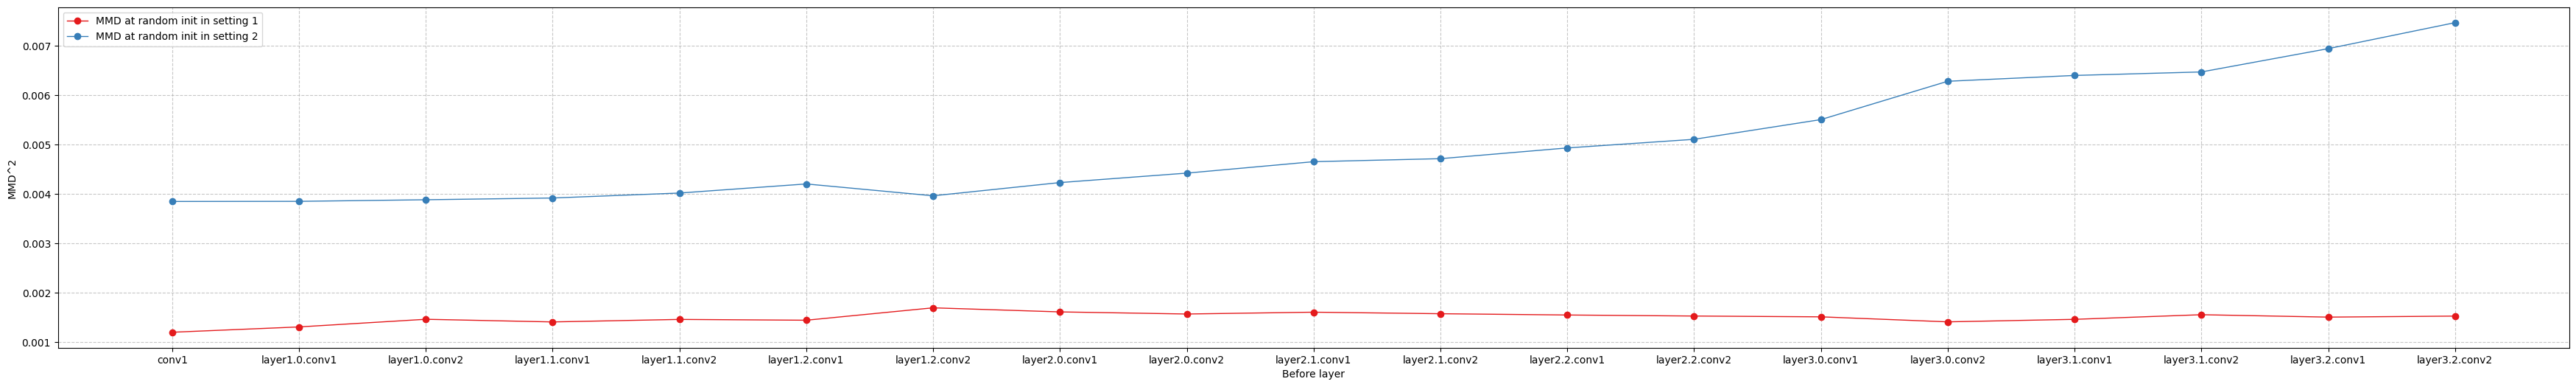

In [22]:
colors = sns.color_palette("Set1")  # You can change "Set1" to other ColorBrewer palettes like "Dark2", "Paired", etc.
x_labels = MMD_mean_at_randominit_setting1.keys()
x_positions = range(len(x_labels))
line_width=1
plt.figure(figsize=(44, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.plot(MMD_mean_at_randominit_setting1.values(), label="MMD at random init in setting 1", color=colors[0], linestyle='-', marker='o', linewidth=line_width)
plt.plot(MMD_mean_at_randominit_setting2.values(), label="MMD at random init in setting 2", color=colors[1], linestyle='-', marker='o', linewidth=line_width)

plt.xlabel('Before layer')
plt.ylabel('MMD^2')
plt.xticks(x_positions, x_labels)
plt.legend(loc='best')

I tried to train first 5 classes to see what happens:

In [23]:
model_S1_Task1 = resnet20()
model_S1_Task1.linear = nn.Linear(model_S1_Task1.linear.in_features, 5)
state_dict = torch.load('/content/drive/MyDrive/projects/base_features_learning/iid_group1.pth', map_location=device)
model_S1_Task1.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
MMD_trained_setting1 = get_MMD_at_every_layer(model_S1_Task1, test_loader_1, test_loader_2)
MMD_trained_setting2 = get_MMD_at_every_layer(model_S1_Task1, test_loader_3, test_loader_4)
torch.cuda.empty_cache()

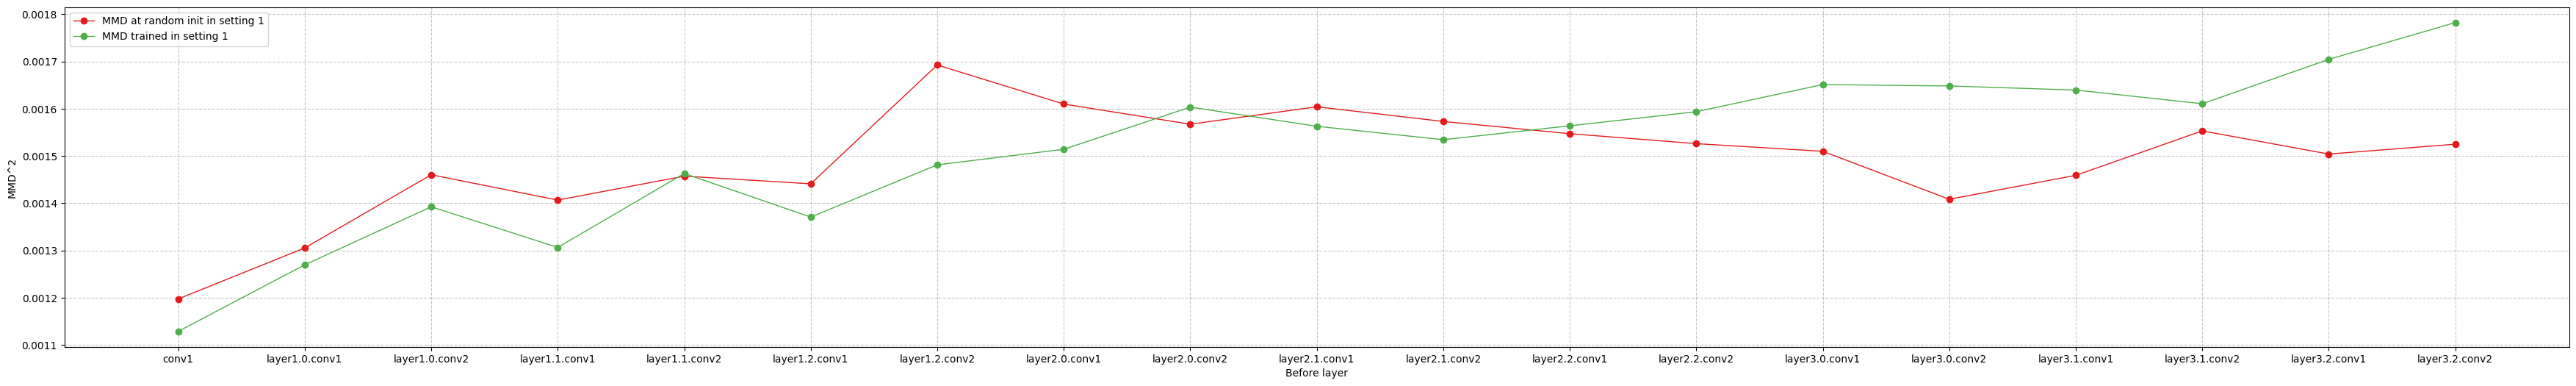

In [25]:
colors = sns.color_palette("Set1")  # You can change "Set1" to other ColorBrewer palettes like "Dark2", "Paired", etc.
x_labels = MMD_mean_at_randominit_setting1.keys()
x_positions = range(len(x_labels))
line_width=1
plt.figure(figsize=(44, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.plot(MMD_mean_at_randominit_setting1.values(), label="MMD at random init in setting 1", color=colors[0], linestyle='-', marker='o', linewidth=line_width)
# plt.plot(MMD_mean_at_randominit_setting2.values(), label="MMD at random init in setting 2", color=colors[1], linestyle='-', marker='o', linewidth=line_width)
plt.plot(MMD_trained_setting1.values(), label="MMD trained in setting 1", color=colors[2], linestyle='-', marker='o', linewidth=line_width)
# plt.plot(MMD_trained_setting2.values(), label="MMD trained in setting 2", color=colors[3], linestyle='-', marker='o', linewidth=line_width)

plt.xlabel('Before layer')
plt.ylabel('MMD^2')
plt.xticks(x_positions, x_labels)
plt.legend(loc='best')

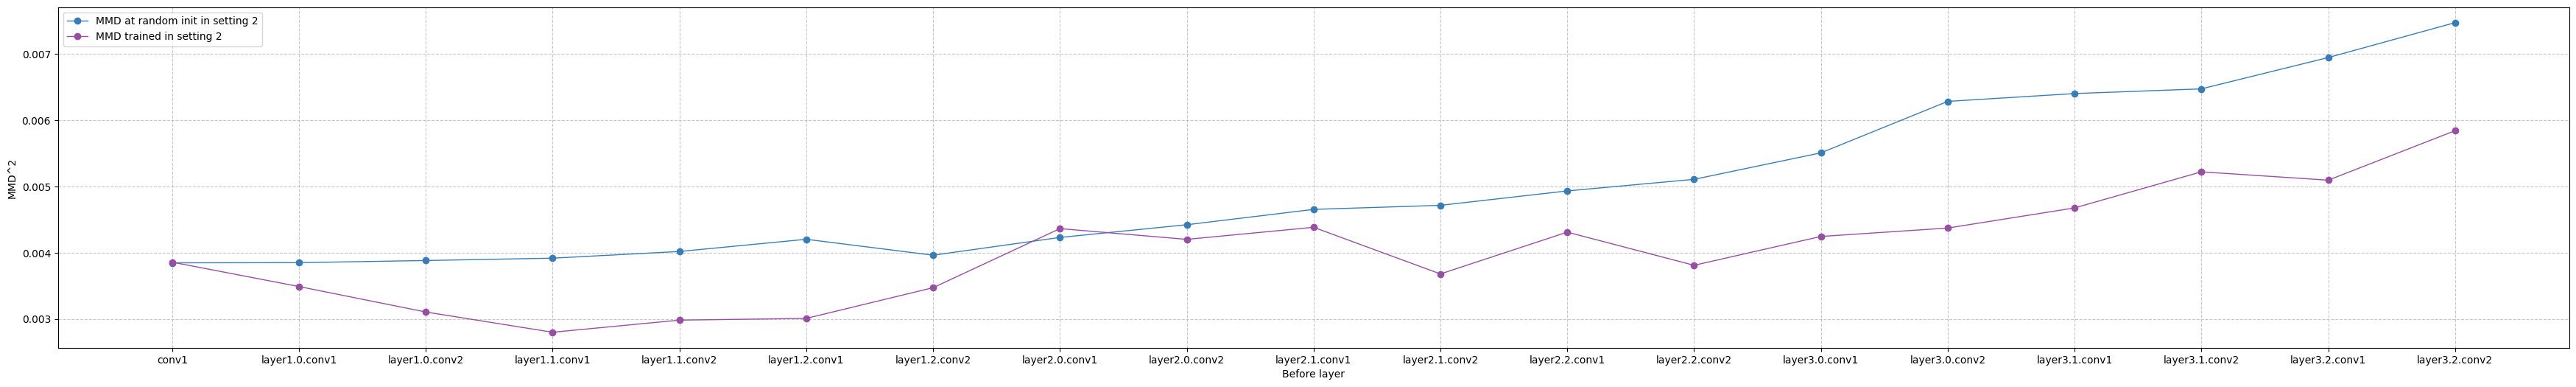

In [26]:
colors = sns.color_palette("Set1")  # You can change "Set1" to other ColorBrewer palettes like "Dark2", "Paired", etc.
x_labels = MMD_mean_at_randominit_setting1.keys()
x_positions = range(len(x_labels))
line_width=1
plt.figure(figsize=(44, 6))
plt.grid(True, linestyle='--', alpha=0.7)
# plt.plot(MMD_mean_at_randominit_setting1.values(), label="MMD at random init in setting 1", color=colors[0], linestyle='-', marker='o', linewidth=line_width)
plt.plot(MMD_mean_at_randominit_setting2.values(), label="MMD at random init in setting 2", color=colors[1], linestyle='-', marker='o', linewidth=line_width)
# plt.plot(MMD_trained_setting1.values(), label="MMD trained in setting 1", color=colors[2], linestyle='-', marker='o', linewidth=line_width)
plt.plot(MMD_trained_setting2.values(), label="MMD trained in setting 2", color=colors[3], linestyle='-', marker='o', linewidth=line_width)

plt.xlabel('Before layer')
plt.ylabel('MMD^2')
plt.xticks(x_positions, x_labels)
plt.legend(loc='best')

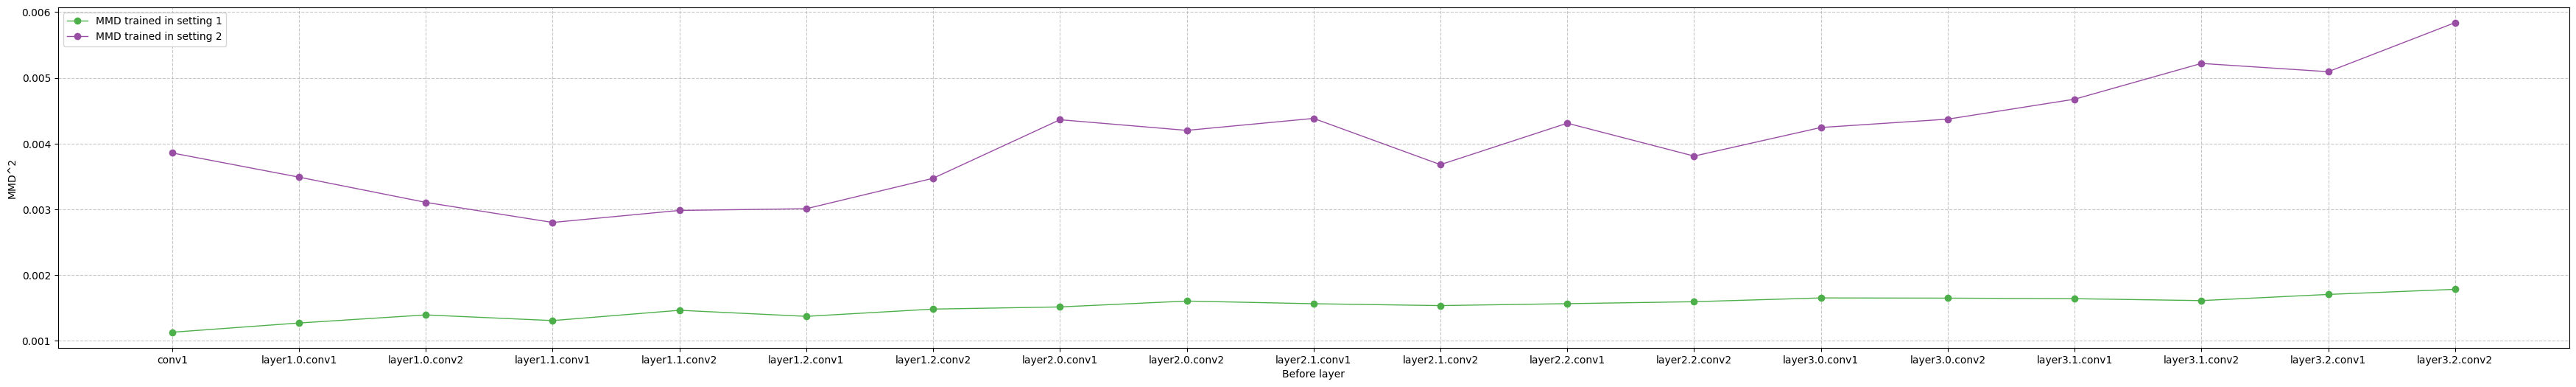

In [27]:
colors = sns.color_palette("Set1")  # You can change "Set1" to other ColorBrewer palettes like "Dark2", "Paired", etc.
x_labels = MMD_mean_at_randominit_setting1.keys()
x_positions = range(len(x_labels))
line_width=1
plt.figure(figsize=(44, 6))
plt.grid(True, linestyle='--', alpha=0.7)
# plt.plot(MMD_mean_at_randominit_setting1.values(), label="MMD at random init in setting 1", color=colors[0], linestyle='-', marker='o', linewidth=line_width)
# plt.plot(MMD_mean_at_randominit_setting2.values(), label="MMD at random init in setting 2", color=colors[1], linestyle='-', marker='o', linewidth=line_width)
plt.plot(MMD_trained_setting1.values(), label="MMD trained in setting 1", color=colors[2], linestyle='-', marker='o', linewidth=line_width)
plt.plot(MMD_trained_setting2.values(), label="MMD trained in setting 2", color=colors[3], linestyle='-', marker='o', linewidth=line_width)

plt.xlabel('Before layer')
plt.ylabel('MMD^2')
plt.xticks(x_positions, x_labels)
plt.legend(loc='best')

In [28]:
differences_random= {}
differences_trained= {}
for key in MMD_trained_setting1.keys():
    differences_random[key] = MMD_mean_at_randominit_setting2[key] - MMD_mean_at_randominit_setting1[key]
    differences_trained[key] = MMD_trained_setting2[key] - MMD_trained_setting1[key]

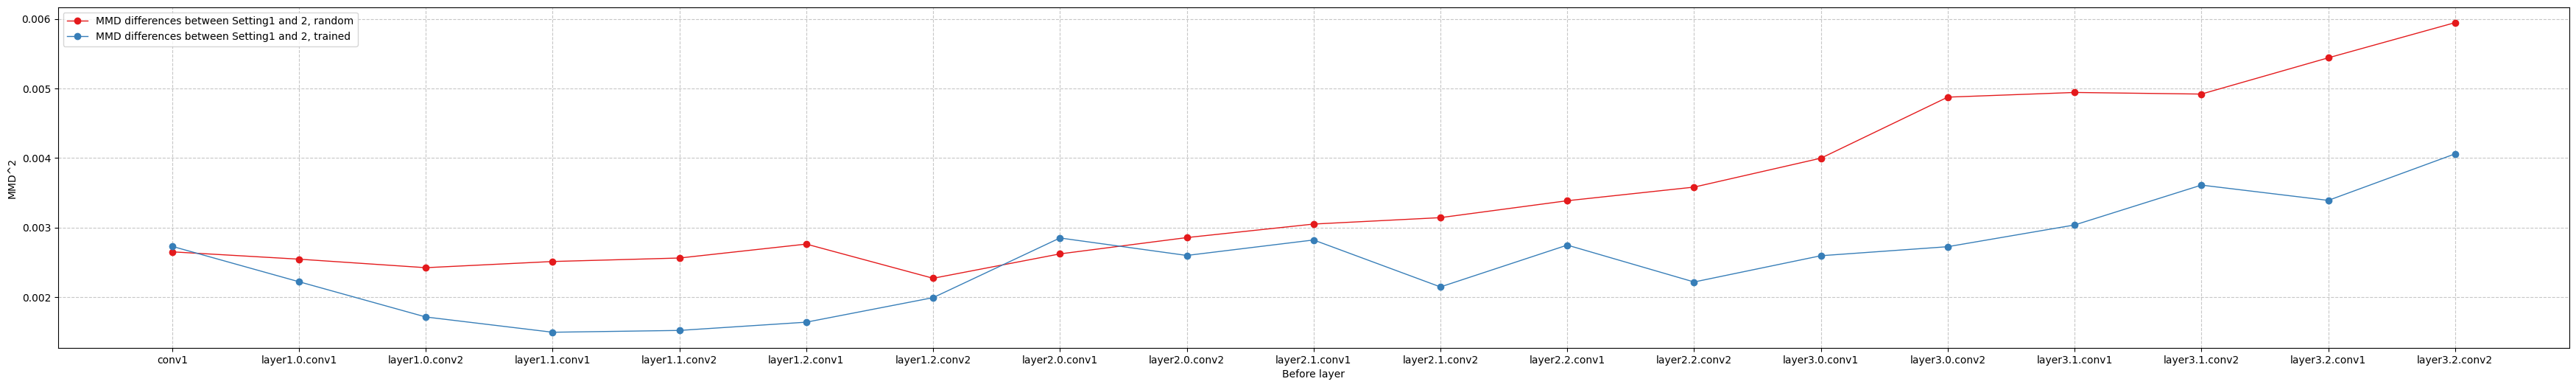

In [29]:
colors = sns.color_palette("Set1")  # You can change "Set1" to other ColorBrewer palettes like "Dark2", "Paired", etc.
x_labels = MMD_mean_at_randominit_setting1.keys()
x_positions = range(len(x_labels))
line_width=1
plt.figure(figsize=(44, 6))
plt.grid(True, linestyle='--', alpha=0.7)
plt.plot(differences_random.values(), label="MMD differences between Setting1 and 2, random", color=colors[0], linestyle='-', marker='o', linewidth=line_width)
plt.plot(differences_trained.values(), label="MMD differences between Setting1 and 2, trained", color=colors[1], linestyle='-', marker='o', linewidth=line_width)

plt.xlabel('Before layer')
plt.ylabel('MMD^2')
plt.xticks(x_positions, x_labels)
plt.legend(loc='best')